The average of goals for the away team is: 1.187587168758717
The average of goals for the home team is: 1.745755783196268
The average of home team winning on non-neutral games is: 50.49194991055456
The country who scored the highest number of goals is:  Zimbabwe


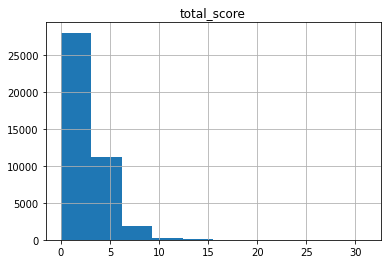

In [34]:
#  import libraries and read data
import pandas
import datetime
df = pandas.read_csv("results.csv")

# --- Averages ---

print("The average of goals for the away team is:", df['away_score'].mean())
print("The average of goals for the home team is:" ,df['home_score'].mean())

# --- total score histogram ---
df['total_score'] = df['away_score'] + df['home_score']
df.hist(column='total_score')

# --- home team’s win percentage ---

# add column based of home_team_won
df['home_team_won'] = df['away_score'] < df['home_score']
# subset of games played on non neutral locations
notNeutralVenuesGame = df[df['neutral'] == False]
# count the games won
homeTeamWonCount = notNeutralVenuesGame.home_team_won.sum()
# claculate proporton
homeTeamWonAverage = (homeTeamWonCount / notNeutralVenuesGame.home_team_won.size) * 100
print("The average of home team winning on non-neutral games is:", homeTeamWonAverage)

# --- Country most goals fifa ---

# subset of fifa events. trim dataset in time, rename to score to later combine

# create date mask and filter out dates that don't fit
df['date'] = pandas.to_datetime(df['date'])  
mask = (df['date'] > datetime.datetime(2010, 1, 11)) & (df['date'] <= datetime.datetime.now())
fifaEvents = fifaEvents.loc[mask]

# keep only FIFA events
fifaEvents = df[df['tournament'].str.contains("FIFA")]

# make two dataframes with scores by away and hpome countries
byCountriesHomeTeam = fifaEvents.groupby('home_team', as_index=False).agg({'home_score': 'sum'}).rename(columns={'home_score': 'score', 'home_team': 'team'})
byCountriesAwayTeam = fifaEvents.groupby('away_team', as_index=False).agg({'away_score': 'sum'}).rename(columns={'away_score': 'score', 'away_team': 'team'})

# concat and then sum the goals
totalByCountry = pandas.concat([byCountriesHomeTeam, byCountriesAwayTeam]).groupby('team', as_index=False).agg({'score' : 'sum'})
countryWithMostGoals = totalByCountry.max()
print("The country who scored the highest number of goals is: ", countryWithMostGoals.team, "with ", countryWithMostGoals.score, " goals")
